## Predikcija slova znakovnog jezika

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

In [2]:
train_data = pd.read_csv("../projekat/data/sign_mnist_train/sign_mnist_train.csv")
test_data = pd.read_csv("../projekat/data/sign_mnist_test/sign_mnist_test.csv")

In [3]:
y_train = train_data['label']
x_train = train_data.drop(["label"],axis=1)

y_test = test_data['label']
x_test = test_data.drop(["label"],axis=1)

In [4]:
label_binrizer = LabelBinarizer()
y_train = label_binrizer.fit_transform(y_train)
y_test = label_binrizer.fit_transform(y_test)

# normalizacija
x_train = x_train/255.0
x_test = x_test/255.0

# pretvaranje u 3D matrice, 1 zasto sto je gray scale pa korsiti samo jedan kanal
x_train = x_train.values.reshape(-1,28,28,1)
x_test = x_test.values.reshape(-1,28,28,1)

In [5]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

Random transformacije nad slikom kako bi se sprečio overfitting i trening skup proširio.

In [10]:
from keras.preprocessing.image import ImageDataGenerator

In [11]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False,  
        vertical_flip=False)  


datagen.fit(x_train)

In [7]:
# building a linear stack of layers with the sequential model
model = Sequential()

# convolutional layer
model.add(Conv2D(32 , (3,3) , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
# convolutional layer
model.add(Conv2D(64 , (3,3) , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
# convolutional layer
model.add(Conv2D(128, (3,3) , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

# flatten output of conv
model.add(BatchNormalization())
model.add(Flatten())

# hidden layer
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(units = 24 , activation = 'softmax'))

# compiling the sequential model
model.compile(optimizer = Adam(lr=0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         7

In [12]:
from keras.callbacks import ModelCheckpoint
from datetime import datetime

checkpointer = ModelCheckpoint(filepath="models/best_weights.hdf5", verbose=1, save_best_only=True) 

start = datetime.now()
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , 
                    validation_data = (x_val, y_val) , callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in: ", duration)

Epoch 1/20
172/172 [==============================] - 144s 816ms/step - loss: 1.9421 - accuracy: 0.4240 - val_loss: 4.2233 - val_accuracy: 0.1218

Epoch 00001: val_loss improved from inf to 4.22331, saving model to models\best_weights.hdf5
Epoch 2/20
172/172 [==============================] - 155s 900ms/step - loss: 0.4281 - accuracy: 0.8648 - val_loss: 3.2908 - val_accuracy: 0.1470

Epoch 00002: val_loss improved from 4.22331 to 3.29085, saving model to models\best_weights.hdf5
Epoch 3/20
172/172 [==============================] - 158s 920ms/step - loss: 0.1989 - accuracy: 0.9415 - val_loss: 0.5499 - val_accuracy: 0.8230

Epoch 00003: val_loss improved from 3.29085 to 0.54991, saving model to models\best_weights.hdf5
Epoch 4/20
172/172 [==============================] - 161s 935ms/step - loss: 0.1216 - accuracy: 0.9621 - val_loss: 0.1072 - val_accuracy: 0.9689

Epoch 00004: val_loss improved from 0.54991 to 0.10718, saving model to models\best_weights.hdf5
Epoch 5/20
172/172 [========

In [13]:
train_score = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", train_score[1])

test_score = model.evaluate(x_val, y_val, verbose=1)
print("Validation Accuracy: ", test_score[1])

test_score = model.evaluate(x_test, y_test, verbose=1)
print("Test Accuracy: ", test_score[1])

687/687 [==============================] - 26s 38ms/step - loss: 0.0376 - accuracy: 0.9873
Training Accuracy:  0.9873429536819458
172/172 [==============================] - 5s 28ms/step - loss: 0.0400 - accuracy: 0.9849 0s - loss: 0.0393 - accu
Validation Accuracy:  0.9848843812942505
225/225 [==============================] - 9s 40ms/step - loss: 0.1529 - accuracy: 0.9582 0s - loss: 0.1545 - accuracy: 
Test Accuracy:  0.9581706523895264


In [14]:
y_pred = model.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred.round())

0.9549637479085332

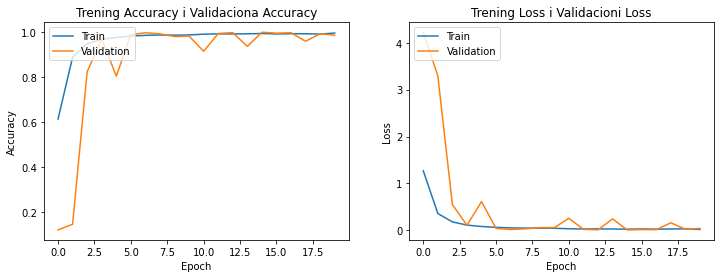

In [16]:
import matplotlib.pyplot as plt

fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Trening Accuracy i Validaciona Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Trening Loss i Validacioni Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

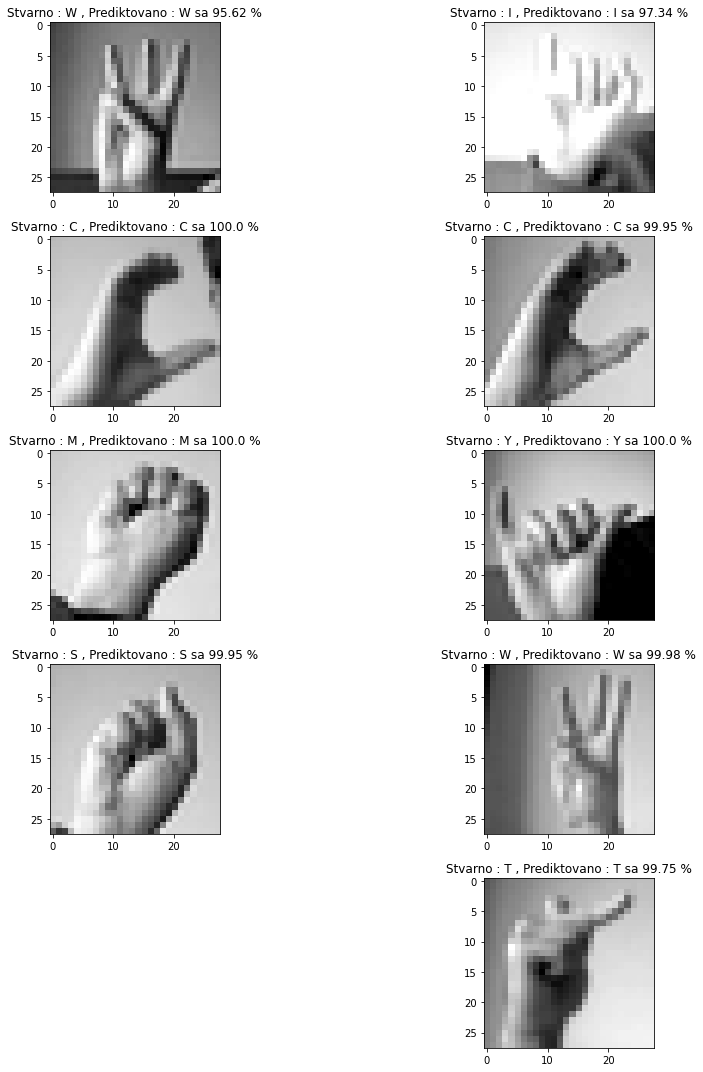

In [18]:
num_letters = {0 : 'A' , 1 : 'B', 2 : 'C' , 3 : 'D', 4: 'E' , 5 : 'F',
                     6 : 'G' , 7 : 'H' , 8 : 'I' , 9 : 'K' , 
                     10 : 'L' , 11 :'M' , 12 : 'N' , 13 : 'O' , 14 : 'P',
                     15 : 'Q' , 16 : 'R' , 17 : 'S' , 18 :'T' , 19 : 'U',
                     20 : 'V' , 21 :'W' , 22 : 'X', 23 : 'Y'}


y_pred = model.predict(x_test)

y_pred2 = np.array([np.argmax(y_pred[i]) for i in range(len(y_pred))])
y_test2 = np.array([np.argmax(y_test[i]) for i in range(len(y_test))])

from sklearn.metrics import confusion_matrix


plt.figure(figsize = (15,15))
for i in range(10):
    ind = np.random.randint(0,len(x_test))
    plt.subplot(5,2,i+1)
    plt.imshow(x_test[ind].reshape(28,28), cmap="gray")
    plt.title('Stvarno : {} , Prediktovano : {} sa {} %'.format(num_letters[y_test2[ind]],
                                                                num_letters[y_pred2[ind]],
                                                                round(y_pred[ind][y_pred2[ind]]*100,2)))
    plt.tight_layout()  